In [2]:
from ecallisto_ng.data_download.hu_dataset import create_overlapping_parquets, load_radio_dataset
from ecallisto_ng.data_download.downloader import get_ecallisto_data
from ecallisto_ng.data_processing.utils import subtract_constant_background
from huggingface_hub import hf_hub_download
import pandas as pd
import torch
import yaml
import pandas as pd
import glob
from datasets import Dataset, Image
from PIL import Image as PILImage

import os
import pandas as pd
from datetime import datetime, timedelta
from ecallisto_ng.data_download.downloader import get_ecallisto_data
from ecallisto_ng.plotting.plotting import plot_spectrogram
from tqdm import tqdm

from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from tqdm import tqdm

from datetime import timedelta, datetime, timezone
from ecallisto_dataset import EcallistoDatasetBinary, custom_resize, remove_background
from ecallisto_model import GrayScaleResNet
torch.set_float32_matmul_precision('high')
def create_logits(model: GrayScaleResNet, dataloader, device):
    model.eval()  # Ensure the model is in evaluation mode
    model.to(device)  # Send the model to the appropriate device
    binary_logits = []

    print("Starting prediction")
    with torch.no_grad():
        for inputs, _, _, _ in tqdm(dataloader):
            y_hat = model(inputs.to(device)).squeeze(dim=1)
            binary_logits.extend(y_hat.cpu().tolist())

    return binary_logits


def load_model(checkpoint_path, config_path):
    # Load configuration
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    # Initialize the model
    model = GrayScaleResNet(
        1,
        resnet_type=config["model"]["model_type"],
        optimizer_name="adam",
        learning_rate=1000,
        label_smoothing=0.0,
    )

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])

    return model, config


def prepare_ecallisto_datasets(ds, config):
    resize_func = Compose(
        [lambda x: custom_resize(x, tuple(config["model"]["input_size"]))]
    )
    ds = ds.add_column("dummy_label", [0] * len(ds))
    edb = EcallistoDatasetBinary(
        ds,
        label_name="dummy_label",
        resize_func=resize_func,
        normalization_transform=remove_background,
    )
    return edb


def prepare_dataloaders(ds, batch_size):
    dataloader = DataLoader(
        ds, batch_size=batch_size, shuffle=False, persistent_workers=False
    )
    return dataloader


/home/kenfus/miniconda3/envs/flaresense-v2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Define repository and filename
repo_id = "i4ds/flaresense"
filename = "model.ckpt"
config_path  = "configs/relabeled_data_best.yml"
# Download the model file
checkpoint_path = hf_hub_download(repo_id=repo_id, filename=filename)


In [7]:
# Create UTC timestamp
datetime_now = datetime.now(timezone.utc).replace(tzinfo=None)

In [8]:
datetime.now(timezone.utc)

datetime.datetime(2024, 12, 12, 13, 2, 8, 632685, tzinfo=datetime.timezone.utc)

In [9]:
datetime_now

datetime.datetime(2024, 12, 12, 13, 2, 8, 625020)

In [10]:
create_overlapping_parquets(
    datetime_now-timedelta(hours=2), 
    datetime_now, 
    ["GERMANY-DLR_63"], 
    'flaresense-data')
ds = load_radio_dataset('flaresense-data/')












Map: 100%|██████████| 9/9 [00:04<00:00,  1.98 examples/s]


In [11]:
ds_e = prepare_ecallisto_datasets(ds, config)

NameError: name 'config' is not defined

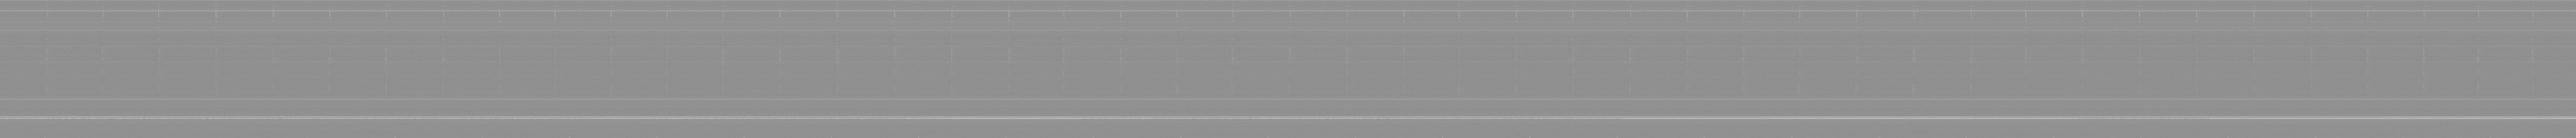

In [ ]:
ds[0]['image']

In [ ]:
data_loader = prepare_dataloaders(ds_e, 32)

In [ ]:
preds = create_logits(model, data_loader, 'cuda')

Starting prediction


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


In [ ]:
ds = ds.add_column("preds", preds)

In [ ]:
ds_bursts = ds.filter(lambda x: x["preds"] > 0)

Filter: 100%|██████████| 129/129 [00:00<00:00, 220.24 examples/s]


In [ ]:
ds_bursts

Dataset({
    features: ['image', 'antenna', 'datetime', 'preds'],
    num_rows: 4
})

In [ ]:
IDX = 4
print(ds_bursts[IDX]['preds'])
data = get_ecallisto_data(ds_bursts[IDX]['datetime'], ds_bursts[IDX]['datetime'] + timedelta(minutes=15), ds_bursts[IDX]['antenna'])[ds_bursts[IDX]['antenna']]
plot_spectrogram(subtract_constant_background(data))

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

In [ ]:
# Construct the CAM object once, and then re-use it on many images:
# Ganzes model gradcam.
target_layers = [module for name, module in model.named_modules() if isinstance(module, torch.nn.Module)]

# Construct the CAM object with all layers
cam = HiResCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(1)]

NameError: name 'model' is not defined

In [ ]:
# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs